# FlowNet tracking

### Run inference with pretrained model

In [1]:
!python3 run_inference.py images/ flownets_EPE1.951.pth --sequence bear

=> will save raw output and RGB visualization
=> fetching img pairs in 'images/'
=> will save everything to images/flow
Making image pairs
image pairs !!!  [[Path('images/bear-001.bmp'), Path('images/bear-002.bmp')], [Path('images/bear-002.bmp'), Path('images/bear-003.bmp')], [Path('images/bear-003.bmp'), Path('images/bear-004.bmp')], [Path('images/bear-004.bmp'), Path('images/bear-005.bmp')], [Path('images/bear-005.bmp'), Path('images/bear-006.bmp')], [Path('images/bear-006.bmp'), Path('images/bear-007.bmp')], [Path('images/bear-007.bmp'), Path('images/bear-008.bmp')], [Path('images/bear-008.bmp'), Path('images/bear-009.bmp')], [Path('images/bear-009.bmp'), Path('images/bear-010.bmp')], [Path('images/bear-010.bmp'), Path('images/bear-011.bmp')], [Path('images/bear-011.bmp'), Path('images/bear-012.bmp')], [Path('images/bear-012.bmp'), Path('images/bear-013.bmp')], [Path('images/bear-013.bmp'), Path('images/bear-014.bmp')], [Path('images/bear-014.bmp'), Path('images/bear-015.bmp')], [Pa

### Tracking

In [37]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100



def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.


def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap


def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))


def propagate_mask(flow, img_current, mask_begin):
    # print(flow.shape)
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint32)
    # print(img_current.shape[0],img_current.shape[1])
    for x in range(img_current.shape[0]-1):
        for y in range(img_current.shape[1]-1):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

def concatenation(unary_flow, to_ref_flow):
    flow = np.zeros((unary_flow.shape[0],unary_flow.shape[1],2), dtype=np.float32)
    x0 = np.arange(0, unary_flow.shape[0])
    y0 = np.arange(0, unary_flow.shape[1])
    xx, yy = np.meshgrid(x0, y0)
    z = to_ref_flow[xx,yy,1]
    fx = interp2d(x0,y0,z,kind='quintic')
    z = to_ref_flow[xx,yy,0]
    fy = interp2d(x0,y0,z,kind='quintic')
    for x in range(unary_flow.shape[0]):
        for y in range(unary_flow.shape[1]):
            flow_x = fx(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow_y = fy(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow[x,y,1] = unary_flow[x,y,1] + flow_x
            flow[x,y,0] = unary_flow[x,y,0] + flow_y
    return flow

In [38]:
from pathlib import Path
from imageio import imread, imwrite
import numpy as np
from glob import glob
import time
from scipy.interpolate import interp2d
import os
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops

In [39]:
img_path = 'images'
flow_path = 'images/flow'
name = 'bear'
preprocess = '_detail_enhance'

flow_files = sorted(glob(os.path.join(flow_path,name + '*.npy')))
img_ext = 'bmp'
mask_ext = 'png'
img_files = sorted(glob(os.path.join(img_path,name + '*.' + img_ext)))
mask_files = sorted(glob(os.path.join(img_path,name + '*.' + mask_ext)))
dices_filename = 'results/dice_'+name+preprocess
fmeasures_filename = 'results/fmeasure_'+name+preprocess
centroid_dist_filename = 'results/centroid_dist_'+name+preprocess

im_begin = 1
im_end = len(img_files)


/tmp/ipykernel_3368780/2859291028.py:154: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fx = interp2d(x0,y0,z,kind='quintic')
/tmp/ipykernel_3368780/2859291028.py:156: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For s

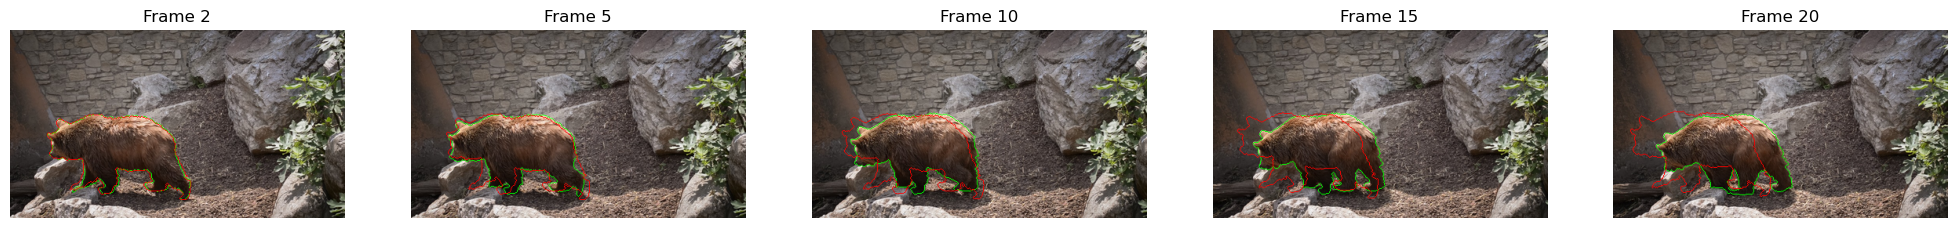

The process took 45.51 seconds
The process took 0.76 minutes


In [41]:


img_begin = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im_begin))).astype(np.float32)/255.
mask_begin = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im_begin)))
seq_dices_FN, seq_fmeasures_FN, centroid_dist_FN = [], [], []
flow_FN_final = np.zeros((img_begin.shape[0], img_begin.shape[1], 2))
start = time.time()
## Plot masks in a row for presentation
plt.figure(figsize=(25,5))
subplot_step = 5
subplot_list = [2,subplot_step,subplot_step*2,subplot_step*3,subplot_step*4]

for im in range(im_begin+1,im_end+1):
  # print(im)
  img_current = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im))).astype(np.float32)/255.
  # print(img_current.shape)
  mask_current = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im)))
  img_precendent = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im-1))).astype(np.float32)/255.

  # flow_FN = np.load(os.path.join(flow_path,name+'-%0*d'%(3,im)+'flow.npy'))
  flow_filename = f"{name}-flow-{im-1:03d}-{im:03d}.npy"
  flow_FN = np.load(os.path.join(flow_path,flow_filename))
  flow_FN_final = concatenation(flow_FN, flow_FN_final)

  flow_FN_resized = cv2.resize(flow_FN_final, (img_current.shape[1], img_current.shape[0]), interpolation=cv2.INTER_LINEAR)

  propagation_FN = propagate_mask(flow_FN_resized, img_current, mask_begin) 
  boundaries_FN = mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation_FN, color=(1,0,0))
  seq_dices_FN.append(dice_assessment(mask_current, propagation_FN))
  seq_fmeasures_FN.append(db_eval_boundary(mask_current, propagation_FN))
  centroid_dist_FN.append(centroid_assessment(mask_current, propagation_FN))

  ## Plot masks in a row for presentation
  if im in subplot_list:
    plt.subplot(1,5,im//subplot_step+1)
    plt.axis('off')
    plt.title("Frame {}".format(im))
    plt.imshow(boundaries_FN)
plt.show()

end = time.time()
print("The process took {:.2f} seconds".format(end-start))
print("The process took {:.2f} minutes".format((end-start)/60))
np.save(dices_filename, seq_dices_FN)
np.save(fmeasures_filename, seq_fmeasures_FN)
np.save(centroid_dist_filename, centroid_dist_FN)

